In [2]:
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import numpy as np
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from preprocessing import fen_to_piece_maps
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cpu"):
    print("Using CPU, not recommended")

In [55]:
def collate_fn(batch):
    batch_fens = [example['fen'] for example in batch]
    labels = torch.tensor(
        [example['target'] for example in batch],
        dtype=torch.float32
    )

    winning_labels = []
    inputs = []

    for example in batch:
        fen = example['fen']
        target = example['target']
        
        # Parse side to move
        stm = fen.split()[1]  # 'w' or 'b'

        # Compute winning label
        if (stm == 'w' and target > 0) or (stm == 'b' and target < 0):
            winning = 1
        else:
            winning = 0

        winning_labels.append(winning)

        # Process input
        inputs.append(torch.tensor(fen_to_piece_maps(fen), dtype=torch.float32))

    inputs = torch.stack(inputs)
    winning_labels = torch.tensor(winning_labels, dtype=torch.float32)  # Make sure it's float32 for BCEWithLogitsLoss etc.

    return inputs, labels, winning_labels

In [56]:
train_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/train"))
val_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/validation"))
test_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/test"))

num_training_examples = len(train_dataset)

train_dataset = train_dataset.to_iterable_dataset(num_shards=32)
val_dataset = val_dataset.to_iterable_dataset()
test_dataset = test_dataset.to_iterable_dataset()

train_dataset = train_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.shuffle(buffer_size=10000)

In [17]:
# dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_part1"))

# # Split the dataset into train, validation, and test sets
# train_size = int(0.98 * len(dataset))
# val_size = int(0.01 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset = dataset.select(range(train_size))
# val_dataset = dataset.select(range(train_size, train_size + val_size))
# test_dataset = dataset.select(range(train_size + val_size, len(dataset)))
# num_training_examples = len(train_dataset)

# train_dataset = dataset.select(range(train_size))
# val_dataset = dataset.select(range(train_size, train_size + val_size))
# test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# # Create a DatasetDict
# dataset_dict = DatasetDict({
#     'train': train_dataset,
#     'validation': val_dataset,
#     'test': test_dataset
# })

# # Save the DatasetDict to disk
# dataset_dict.save_to_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split"))

# Convert to iterable datasets
# train_dataset = train_dataset.dataset.to_iterable_dataset(num_shards=32)
# val_dataset = val_dataset.dataset.to_iterable_dataset()
# test_dataset = test_dataset.dataset.to_iterable_dataset()

# train_dataset = train_dataset.shuffle(buffer_size=10000)
# val_dataset = val_dataset.shuffle(buffer_size=10000)
# test_dataset = test_dataset.shuffle(buffer_size=10000)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, collate_fn=collate_fn)

In [66]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

# Resnet-Like
class ChessEvalResNet(nn.Module):
    def __init__(self, input_planes=17, channels=64, num_blocks=4):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_planes, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(channels) for _ in range(num_blocks)]
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # Two heads
        self.eval_head = nn.Linear(channels, 1)  # for regression (evaluation)
        self.win_head = nn.Linear(channels, 1)   # for binary classification (winning)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.residual_blocks(x)
        x = self.global_pool(x).view(x.size(0), -1)  # shape: (batch_size, channels)

        eval_pred = self.eval_head(x)   # output shape: (batch_size, 1)
        win_pred = self.win_head(x)     # output shape: (batch_size, 1)

        return eval_pred, win_pred

In [67]:
input_tensor = torch.randn(32, 17, 8, 8)  # A batch of 32 chessboard positions

model = ChessEvalResNet()
output = model(input_tensor)

print(output[0].shape, output[1].shape)

torch.Size([32, 1]) torch.Size([32, 1])


In [68]:
NUM_EPOCHS = 1
total_iters = NUM_EPOCHS * ((num_training_examples // 256) + 1)
print(total_iters)

model = ChessEvalResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=total_iters, eta_min=1e-4)
eval_criterion = nn.MSELoss()
win_criterion = nn.BCEWithLogitsLoss()

229688


In [69]:
best_val_loss = float('inf')
best_val_mae = float('inf')
num_iterations = 0
patience_counter = 0

PATIENCE = 30000
MIN_IMPROVEMENT = 5e-4
VAL_ITERS = 5000
LOG_ITERS = 1000

early_stop = False

steps = []
train_losses, train_maes, train_win_accs = [], [], []
val_losses, val_maes, val_win_accs = [], [], []

for epoch in range(1, NUM_EPOCHS + 1):
    if early_stop:
        break

    model.train()
    total_loss = 0.0
    total_mae = 0.0
    total_win_correct = 0
    total_samples = 0

    for inputs, labels, winning_labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        inputs, labels, winning_labels = inputs.to(DEVICE), labels.to(DEVICE), winning_labels.to(DEVICE)

        optimizer.zero_grad()
        eval_pred, win_pred = model(inputs)

        loss_eval = eval_criterion(eval_pred.squeeze(), labels)
        loss_win = win_criterion(win_pred.squeeze(), winning_labels)

        loss = loss_eval + loss_win

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_loss = loss.item()
        batch_mae = torch.mean(torch.abs(eval_pred.squeeze() - labels)).item()

        # Calculate batch binary accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        batch_win_acc = (win_pred_labels == winning_labels).float().mean().item()

        total_loss += batch_loss * inputs.size(0)
        total_mae += batch_mae * inputs.size(0)
        total_win_correct += (win_pred_labels == winning_labels).sum().item()
        total_samples += inputs.size(0)
        num_iterations += 1

        if num_iterations % LOG_ITERS == 0:
            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}")

    # Validation every VAL_ITERS iterations
        if num_iterations % VAL_ITERS == 0:
            model.eval()
            val_loss_sum = 0.0
            val_mae_sum = 0.0
            val_win_correct = 0
            val_total_samples = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_winning_labels in val_loader:
                    val_inputs, val_labels, val_winning_labels = val_inputs.to(DEVICE), val_labels.to(DEVICE), val_winning_labels.to(DEVICE)

                    val_pred, val_win_pred = model(val_inputs)

                    val_loss = eval_criterion(val_pred.squeeze(), val_labels)
                    val_mae = torch.mean(torch.abs(val_pred.squeeze() - val_labels))

                    val_loss_sum += val_loss.item() * val_inputs.size(0)
                    val_mae_sum += val_mae.item() * val_inputs.size(0)

                    val_win_preds = (torch.sigmoid(val_win_pred.squeeze()) > 0.5).float()
                    val_win_correct += (val_win_preds == val_winning_labels).sum().item()

                    val_total_samples += val_inputs.size(0)

            avg_val_loss = val_loss_sum / val_total_samples
            avg_val_mae = val_mae_sum / val_total_samples
            avg_val_win_acc = val_win_correct / val_total_samples

            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"\n[Validation] Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}, val_loss: {avg_val_loss:.4f}, val_mae: {avg_val_mae:.4f}, val_win_acc: {avg_val_win_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

            steps.append(num_iterations)
            train_losses.append(avg_train_loss)
            train_maes.append(avg_train_mae)
            train_win_accs.append(avg_train_win_acc)

            val_losses.append(avg_val_loss)
            val_maes.append(avg_val_mae)
            val_win_accs.append(avg_val_win_acc)

            # Checkpoint best
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_chess_mlp.pth")
                print(f"Saved new best model after {num_iterations} iters")
            
            # Early stopping on validation MAE
            if avg_val_mae + MIN_IMPROVEMENT < best_val_mae:
                best_val_mae = avg_val_mae
                patience_counter = 0
                print(f"--------Validation MAE improved to {best_val_mae:.6f}--------")
            else:
                patience_counter += VAL_ITERS
                print(f"--------No significant MAE improvement for {patience_counter} iterations--------")

            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at {num_iterations} iterations (no significant MAE improvement)")
                early_stop = True
                break

            model.train()


Epoch 1: 1004it [00:31, 31.50it/s]

Step 1000 — train_loss: 0.7182, train_mae: 0.2555, train_win_acc: 0.6874


Epoch 1: 2004it [01:02, 31.64it/s]

Step 2000 — train_loss: 0.6645, train_mae: 0.2389, train_win_acc: 0.7140


Epoch 1: 3003it [01:34, 31.18it/s]

Step 3000 — train_loss: 0.6444, train_mae: 0.2326, train_win_acc: 0.7241


Epoch 1: 4007it [02:05, 32.83it/s]

Step 4000 — train_loss: 0.6351, train_mae: 0.2285, train_win_acc: 0.7294


Epoch 1: 4999it [02:37, 30.48it/s]

Step 5000 — train_loss: 0.6257, train_mae: 0.2262, train_win_acc: 0.7352


Epoch 1: 5004it [03:41,  4.01s/it]


[Validation] Step 5000 — train_loss: 0.6257, train_mae: 0.2262, train_win_acc: 0.7352, val_loss: 0.1174, val_mae: 0.2342, val_win_acc: 0.6795, LR: 0.002997
Saved new best model after 5000 iters
--------Validation MAE improved to 0.234213--------


Epoch 1: 6005it [04:13, 32.42it/s]

Step 6000 — train_loss: 0.6177, train_mae: 0.2238, train_win_acc: 0.7398


Epoch 1: 7003it [04:45, 31.79it/s]

Step 7000 — train_loss: 0.6125, train_mae: 0.2218, train_win_acc: 0.7428


Epoch 1: 8007it [05:17, 31.42it/s]

Step 8000 — train_loss: 0.6078, train_mae: 0.2197, train_win_acc: 0.7452


Epoch 1: 9004it [05:49, 30.37it/s]

Step 9000 — train_loss: 0.6033, train_mae: 0.2174, train_win_acc: 0.7475


Epoch 1: 9997it [06:22, 30.41it/s]

Step 10000 — train_loss: 0.5998, train_mae: 0.2157, train_win_acc: 0.7493


Epoch 1: 10003it [07:26,  3.90s/it]


[Validation] Step 10000 — train_loss: 0.5998, train_mae: 0.2157, train_win_acc: 0.7493, val_loss: 0.1028, val_mae: 0.2209, val_win_acc: 0.7230, LR: 0.002986
Saved new best model after 10000 iters
--------Validation MAE improved to 0.220874--------


Epoch 1: 11004it [08:00, 29.49it/s]

Step 11000 — train_loss: 0.5968, train_mae: 0.2143, train_win_acc: 0.7510


Epoch 1: 12005it [08:32, 32.34it/s]

Step 12000 — train_loss: 0.5941, train_mae: 0.2132, train_win_acc: 0.7524


Epoch 1: 13007it [09:05, 31.53it/s]

Step 13000 — train_loss: 0.5904, train_mae: 0.2120, train_win_acc: 0.7545


Epoch 1: 14005it [09:38, 30.24it/s]

Step 14000 — train_loss: 0.5880, train_mae: 0.2108, train_win_acc: 0.7557


Epoch 1: 14996it [10:11, 30.89it/s]

Step 15000 — train_loss: 0.5825, train_mae: 0.2105, train_win_acc: 0.7592


Epoch 1: 15003it [11:15,  3.74s/it]


[Validation] Step 15000 — train_loss: 0.5825, train_mae: 0.2105, train_win_acc: 0.7592, val_loss: 0.1138, val_mae: 0.2298, val_win_acc: 0.7160, LR: 0.002970
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 16004it [11:48, 30.72it/s]

Step 16000 — train_loss: 0.5780, train_mae: 0.2116, train_win_acc: 0.7629


Epoch 1: 17004it [12:21, 29.41it/s]

Step 17000 — train_loss: 0.5757, train_mae: 0.2108, train_win_acc: 0.7642


Epoch 1: 18006it [12:55, 30.22it/s]

Step 18000 — train_loss: 0.5741, train_mae: 0.2101, train_win_acc: 0.7652


Epoch 1: 19006it [13:26, 31.77it/s]

Step 19000 — train_loss: 0.5723, train_mae: 0.2091, train_win_acc: 0.7660


Epoch 1: 19998it [13:57, 30.89it/s]

Step 20000 — train_loss: 0.5708, train_mae: 0.2083, train_win_acc: 0.7669


Epoch 1: 20003it [15:02,  4.14s/it]


[Validation] Step 20000 — train_loss: 0.5708, train_mae: 0.2083, train_win_acc: 0.7669, val_loss: 0.1003, val_mae: 0.2104, val_win_acc: 0.7287, LR: 0.002946
Saved new best model after 20000 iters
--------Validation MAE improved to 0.210374--------


Epoch 1: 21004it [15:35, 30.70it/s]

Step 21000 — train_loss: 0.5691, train_mae: 0.2076, train_win_acc: 0.7678


Epoch 1: 22005it [16:07, 31.64it/s]

Step 22000 — train_loss: 0.5676, train_mae: 0.2068, train_win_acc: 0.7684


Epoch 1: 23005it [16:39, 31.54it/s]

Step 23000 — train_loss: 0.5664, train_mae: 0.2061, train_win_acc: 0.7690


Epoch 1: 24007it [17:10, 31.33it/s]

Step 24000 — train_loss: 0.5647, train_mae: 0.2053, train_win_acc: 0.7697


Epoch 1: 24996it [17:42, 30.40it/s]

Step 25000 — train_loss: 0.5631, train_mae: 0.2046, train_win_acc: 0.7705


Epoch 1: 25004it [18:46,  3.38s/it]


[Validation] Step 25000 — train_loss: 0.5631, train_mae: 0.2046, train_win_acc: 0.7705, val_loss: 0.0895, val_mae: 0.1952, val_win_acc: 0.7533, LR: 0.002916
Saved new best model after 25000 iters
--------Validation MAE improved to 0.195178--------


Epoch 1: 26004it [19:17, 30.85it/s]

Step 26000 — train_loss: 0.5610, train_mae: 0.2038, train_win_acc: 0.7714


Epoch 1: 27004it [19:48, 33.02it/s]

Step 27000 — train_loss: 0.5592, train_mae: 0.2030, train_win_acc: 0.7722


Epoch 1: 28005it [20:19, 30.38it/s]

Step 28000 — train_loss: 0.5575, train_mae: 0.2022, train_win_acc: 0.7730


Epoch 1: 29005it [20:52, 30.05it/s]

Step 29000 — train_loss: 0.5556, train_mae: 0.2015, train_win_acc: 0.7739


Epoch 1: 29998it [21:25, 30.67it/s]

Step 30000 — train_loss: 0.5543, train_mae: 0.2008, train_win_acc: 0.7744


Epoch 1: 30004it [22:29,  3.77s/it]


[Validation] Step 30000 — train_loss: 0.5543, train_mae: 0.2008, train_win_acc: 0.7744, val_loss: 0.0868, val_mae: 0.1911, val_win_acc: 0.7518, LR: 0.002880
Saved new best model after 30000 iters
--------Validation MAE improved to 0.191054--------


Epoch 1: 31003it [23:02, 30.39it/s]

Step 31000 — train_loss: 0.5527, train_mae: 0.2001, train_win_acc: 0.7752


Epoch 1: 32006it [23:34, 31.42it/s]

Step 32000 — train_loss: 0.5511, train_mae: 0.1995, train_win_acc: 0.7759


Epoch 1: 33006it [24:05, 31.69it/s]

Step 33000 — train_loss: 0.5497, train_mae: 0.1989, train_win_acc: 0.7764


Epoch 1: 34006it [24:36, 33.14it/s]

Step 34000 — train_loss: 0.5487, train_mae: 0.1983, train_win_acc: 0.7769


Epoch 1: 34998it [25:07, 32.55it/s]

Step 35000 — train_loss: 0.5474, train_mae: 0.1978, train_win_acc: 0.7774


Epoch 1: 35004it [26:13,  3.85s/it]


[Validation] Step 35000 — train_loss: 0.5474, train_mae: 0.1978, train_win_acc: 0.7774, val_loss: 0.0865, val_mae: 0.1957, val_win_acc: 0.7593, LR: 0.002837
Saved new best model after 35000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 36003it [26:44, 31.40it/s]

Step 36000 — train_loss: 0.5462, train_mae: 0.1972, train_win_acc: 0.7779


Epoch 1: 37007it [27:15, 31.30it/s]

Step 37000 — train_loss: 0.5450, train_mae: 0.1967, train_win_acc: 0.7785


Epoch 1: 38007it [27:46, 31.33it/s]

Step 38000 — train_loss: 0.5440, train_mae: 0.1963, train_win_acc: 0.7790


Epoch 1: 39004it [28:18, 31.06it/s]

Step 39000 — train_loss: 0.5429, train_mae: 0.1958, train_win_acc: 0.7795


Epoch 1: 39998it [28:50, 31.32it/s]

Step 40000 — train_loss: 0.5418, train_mae: 0.1953, train_win_acc: 0.7800


Epoch 1: 40003it [29:56,  4.28s/it]


[Validation] Step 40000 — train_loss: 0.5418, train_mae: 0.1953, train_win_acc: 0.7800, val_loss: 0.0875, val_mae: 0.1960, val_win_acc: 0.7565, LR: 0.002788
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 41006it [30:29, 30.31it/s]

Step 41000 — train_loss: 0.5407, train_mae: 0.1949, train_win_acc: 0.7805


Epoch 1: 42003it [31:02, 30.22it/s]

Step 42000 — train_loss: 0.5393, train_mae: 0.1943, train_win_acc: 0.7810


Epoch 1: 43003it [31:35, 30.52it/s]

Step 43000 — train_loss: 0.5381, train_mae: 0.1938, train_win_acc: 0.7815


Epoch 1: 44004it [32:08, 30.67it/s]

Step 44000 — train_loss: 0.5373, train_mae: 0.1934, train_win_acc: 0.7819


Epoch 1: 44996it [32:40, 30.80it/s]

Step 45000 — train_loss: 0.5365, train_mae: 0.1930, train_win_acc: 0.7823


Epoch 1: 45003it [33:45,  3.67s/it]


[Validation] Step 45000 — train_loss: 0.5365, train_mae: 0.1930, train_win_acc: 0.7823, val_loss: 0.0802, val_mae: 0.1822, val_win_acc: 0.7669, LR: 0.002734
Saved new best model after 45000 iters
--------Validation MAE improved to 0.182213--------


Epoch 1: 46004it [34:18, 30.45it/s]

Step 46000 — train_loss: 0.5358, train_mae: 0.1927, train_win_acc: 0.7827


Epoch 1: 47006it [34:51, 30.13it/s]

Step 47000 — train_loss: 0.5349, train_mae: 0.1924, train_win_acc: 0.7831


Epoch 1: 48005it [35:24, 29.72it/s]

Step 48000 — train_loss: 0.5341, train_mae: 0.1920, train_win_acc: 0.7835


Epoch 1: 49005it [35:57, 30.57it/s]

Step 49000 — train_loss: 0.5333, train_mae: 0.1916, train_win_acc: 0.7839


Epoch 1: 49998it [36:30, 29.59it/s]

Step 50000 — train_loss: 0.5324, train_mae: 0.1913, train_win_acc: 0.7843


Epoch 1: 50003it [37:34,  4.84s/it]


[Validation] Step 50000 — train_loss: 0.5324, train_mae: 0.1913, train_win_acc: 0.7843, val_loss: 0.0812, val_mae: 0.1832, val_win_acc: 0.7715, LR: 0.002674
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 51004it [38:06, 29.96it/s]

Step 51000 — train_loss: 0.5316, train_mae: 0.1910, train_win_acc: 0.7847


Epoch 1: 52007it [38:38, 33.22it/s]

Step 52000 — train_loss: 0.5309, train_mae: 0.1907, train_win_acc: 0.7850


Epoch 1: 53006it [39:09, 31.96it/s]

Step 53000 — train_loss: 0.5301, train_mae: 0.1904, train_win_acc: 0.7854


Epoch 1: 54006it [39:40, 32.50it/s]

Step 54000 — train_loss: 0.5294, train_mae: 0.1902, train_win_acc: 0.7857


Epoch 1: 54998it [40:10, 32.71it/s]

Step 55000 — train_loss: 0.5284, train_mae: 0.1898, train_win_acc: 0.7862


Epoch 1: 55003it [41:15,  4.15s/it]


[Validation] Step 55000 — train_loss: 0.5284, train_mae: 0.1898, train_win_acc: 0.7862, val_loss: 0.0797, val_mae: 0.1821, val_win_acc: 0.7747, LR: 0.002609
Saved new best model after 55000 iters
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 56004it [41:48, 29.43it/s]

Step 56000 — train_loss: 0.5275, train_mae: 0.1895, train_win_acc: 0.7866


Epoch 1: 57003it [42:20, 30.83it/s]

Step 57000 — train_loss: 0.5268, train_mae: 0.1892, train_win_acc: 0.7869


Epoch 1: 58003it [42:53, 29.65it/s]

Step 58000 — train_loss: 0.5262, train_mae: 0.1889, train_win_acc: 0.7872


Epoch 1: 59006it [43:25, 32.21it/s]

Step 59000 — train_loss: 0.5254, train_mae: 0.1887, train_win_acc: 0.7875


Epoch 1: 59998it [43:57, 30.86it/s]

Step 60000 — train_loss: 0.5246, train_mae: 0.1883, train_win_acc: 0.7879


Epoch 1: 60003it [45:02,  4.22s/it]


[Validation] Step 60000 — train_loss: 0.5246, train_mae: 0.1883, train_win_acc: 0.7879, val_loss: 0.0795, val_mae: 0.1855, val_win_acc: 0.7565, LR: 0.002539
Saved new best model after 60000 iters
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 61006it [45:34, 30.83it/s]

Step 61000 — train_loss: 0.5238, train_mae: 0.1880, train_win_acc: 0.7882


Epoch 1: 62005it [46:07, 29.78it/s]

Step 62000 — train_loss: 0.5232, train_mae: 0.1877, train_win_acc: 0.7885


Epoch 1: 63003it [46:38, 32.53it/s]

Step 63000 — train_loss: 0.5226, train_mae: 0.1874, train_win_acc: 0.7887


Epoch 1: 64005it [47:09, 30.93it/s]

Step 64000 — train_loss: 0.5219, train_mae: 0.1872, train_win_acc: 0.7890


Epoch 1: 64997it [47:41, 31.36it/s]

Step 65000 — train_loss: 0.5213, train_mae: 0.1869, train_win_acc: 0.7893


Epoch 1: 65003it [48:46,  3.92s/it]


[Validation] Step 65000 — train_loss: 0.5213, train_mae: 0.1869, train_win_acc: 0.7893, val_loss: 0.0756, val_mae: 0.1742, val_win_acc: 0.7831, LR: 0.002464
Saved new best model after 65000 iters
--------Validation MAE improved to 0.174213--------


Epoch 1: 66003it [49:19, 30.12it/s]

Step 66000 — train_loss: 0.5206, train_mae: 0.1866, train_win_acc: 0.7896


Epoch 1: 67003it [49:52, 25.28it/s]

Step 67000 — train_loss: 0.5199, train_mae: 0.1864, train_win_acc: 0.7899


Epoch 1: 68005it [50:30, 25.98it/s]

Step 68000 — train_loss: 0.5192, train_mae: 0.1861, train_win_acc: 0.7902


Epoch 1: 69005it [51:07, 29.87it/s]

Step 69000 — train_loss: 0.5187, train_mae: 0.1859, train_win_acc: 0.7904


Epoch 1: 69998it [51:43, 27.24it/s]

Step 70000 — train_loss: 0.5180, train_mae: 0.1856, train_win_acc: 0.7907


Epoch 1: 70003it [52:52,  5.18s/it]


[Validation] Step 70000 — train_loss: 0.5180, train_mae: 0.1856, train_win_acc: 0.7907, val_loss: 0.0780, val_mae: 0.1813, val_win_acc: 0.7709, LR: 0.002385
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 71005it [53:25, 28.59it/s]

Step 71000 — train_loss: 0.5174, train_mae: 0.1853, train_win_acc: 0.7910


Epoch 1: 72002it [53:58, 29.11it/s]

Step 72000 — train_loss: 0.5167, train_mae: 0.1851, train_win_acc: 0.7913


Epoch 1: 73005it [54:31, 29.59it/s]

Step 73000 — train_loss: 0.5162, train_mae: 0.1849, train_win_acc: 0.7915


Epoch 1: 74003it [55:05, 27.78it/s]

Step 74000 — train_loss: 0.5155, train_mae: 0.1847, train_win_acc: 0.7918


Epoch 1: 74996it [55:39, 31.43it/s]

Step 75000 — train_loss: 0.5149, train_mae: 0.1844, train_win_acc: 0.7921


Epoch 1: 75004it [56:46,  3.54s/it]


[Validation] Step 75000 — train_loss: 0.5149, train_mae: 0.1844, train_win_acc: 0.7921, val_loss: 0.0809, val_mae: 0.1833, val_win_acc: 0.7771, LR: 0.002302
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 76005it [57:19, 30.61it/s]

Step 76000 — train_loss: 0.5143, train_mae: 0.1842, train_win_acc: 0.7924


Epoch 1: 77004it [57:50, 31.94it/s]

Step 77000 — train_loss: 0.5137, train_mae: 0.1840, train_win_acc: 0.7926


Epoch 1: 78005it [58:22, 30.18it/s]

Step 78000 — train_loss: 0.5131, train_mae: 0.1838, train_win_acc: 0.7929


Epoch 1: 79006it [58:55, 30.19it/s]

Step 79000 — train_loss: 0.5124, train_mae: 0.1835, train_win_acc: 0.7932


Epoch 1: 79997it [59:28, 30.50it/s]

Step 80000 — train_loss: 0.5117, train_mae: 0.1832, train_win_acc: 0.7935


Epoch 1: 80003it [1:00:32,  3.90s/it]


[Validation] Step 80000 — train_loss: 0.5117, train_mae: 0.1832, train_win_acc: 0.7935, val_loss: 0.0738, val_mae: 0.1690, val_win_acc: 0.7848, LR: 0.002215
Saved new best model after 80000 iters
--------Validation MAE improved to 0.168989--------


Epoch 1: 81007it [1:01:05, 32.30it/s]

Step 81000 — train_loss: 0.5111, train_mae: 0.1830, train_win_acc: 0.7938


Epoch 1: 82005it [1:01:38, 30.84it/s]

Step 82000 — train_loss: 0.5106, train_mae: 0.1828, train_win_acc: 0.7940


Epoch 1: 83003it [1:02:10, 30.30it/s]

Step 83000 — train_loss: 0.5101, train_mae: 0.1826, train_win_acc: 0.7942


Epoch 1: 84006it [1:02:43, 30.25it/s]

Step 84000 — train_loss: 0.5095, train_mae: 0.1824, train_win_acc: 0.7945


Epoch 1: 84997it [1:03:15, 29.35it/s]

Step 85000 — train_loss: 0.5090, train_mae: 0.1821, train_win_acc: 0.7947


Epoch 1: 85004it [1:04:25,  4.37s/it]


[Validation] Step 85000 — train_loss: 0.5090, train_mae: 0.1821, train_win_acc: 0.7947, val_loss: 0.0723, val_mae: 0.1699, val_win_acc: 0.7865, LR: 0.002126
Saved new best model after 85000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 86004it [1:04:59, 29.69it/s]

Step 86000 — train_loss: 0.5085, train_mae: 0.1819, train_win_acc: 0.7949


Epoch 1: 87004it [1:05:32, 29.96it/s]

Step 87000 — train_loss: 0.5079, train_mae: 0.1817, train_win_acc: 0.7951


Epoch 1: 88004it [1:06:06, 26.94it/s]

Step 88000 — train_loss: 0.5072, train_mae: 0.1814, train_win_acc: 0.7954


Epoch 1: 89003it [1:06:40, 29.11it/s]

Step 89000 — train_loss: 0.5066, train_mae: 0.1812, train_win_acc: 0.7957


Epoch 1: 89997it [1:07:14, 29.44it/s]

Step 90000 — train_loss: 0.5060, train_mae: 0.1810, train_win_acc: 0.7959


Epoch 1: 90003it [1:08:19,  4.34s/it]


[Validation] Step 90000 — train_loss: 0.5060, train_mae: 0.1810, train_win_acc: 0.7959, val_loss: 0.0730, val_mae: 0.1736, val_win_acc: 0.7937, LR: 0.002033
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 91003it [1:08:52, 32.64it/s]

Step 91000 — train_loss: 0.5056, train_mae: 0.1808, train_win_acc: 0.7961


Epoch 1: 92003it [1:09:23, 31.72it/s]

Step 92000 — train_loss: 0.5051, train_mae: 0.1806, train_win_acc: 0.7963


Epoch 1: 93007it [1:09:54, 31.72it/s]

Step 93000 — train_loss: 0.5046, train_mae: 0.1805, train_win_acc: 0.7966


Epoch 1: 94003it [1:10:25, 31.41it/s]

Step 94000 — train_loss: 0.5042, train_mae: 0.1803, train_win_acc: 0.7968


Epoch 1: 94999it [1:10:57, 31.80it/s]

Step 95000 — train_loss: 0.5037, train_mae: 0.1801, train_win_acc: 0.7970


Epoch 1: 95004it [1:12:01,  4.03s/it]


[Validation] Step 95000 — train_loss: 0.5037, train_mae: 0.1801, train_win_acc: 0.7970, val_loss: 0.0705, val_mae: 0.1689, val_win_acc: 0.7956, LR: 0.001939
Saved new best model after 95000 iters
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 96006it [1:12:33, 30.73it/s]

Step 96000 — train_loss: 0.5031, train_mae: 0.1798, train_win_acc: 0.7972


Epoch 1: 97006it [1:13:06, 31.54it/s]

Step 97000 — train_loss: 0.5026, train_mae: 0.1796, train_win_acc: 0.7974


Epoch 1: 98006it [1:13:38, 30.54it/s]

Step 98000 — train_loss: 0.5020, train_mae: 0.1794, train_win_acc: 0.7977


Epoch 1: 99006it [1:14:11, 29.92it/s]

Step 99000 — train_loss: 0.5014, train_mae: 0.1792, train_win_acc: 0.7979


Epoch 1: 99997it [1:14:44, 29.66it/s]

Step 100000 — train_loss: 0.5009, train_mae: 0.1790, train_win_acc: 0.7982


Epoch 1: 100003it [1:15:48,  4.51s/it]


[Validation] Step 100000 — train_loss: 0.5009, train_mae: 0.1790, train_win_acc: 0.7982, val_loss: 0.0726, val_mae: 0.1697, val_win_acc: 0.7823, LR: 0.001842
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 101006it [1:16:22, 30.12it/s]

Step 101000 — train_loss: 0.5005, train_mae: 0.1788, train_win_acc: 0.7983


Epoch 1: 102003it [1:16:54, 29.04it/s]

Step 102000 — train_loss: 0.5001, train_mae: 0.1787, train_win_acc: 0.7985


Epoch 1: 103005it [1:17:27, 30.33it/s]

Step 103000 — train_loss: 0.4997, train_mae: 0.1786, train_win_acc: 0.7987


Epoch 1: 104004it [1:18:00, 30.73it/s]

Step 104000 — train_loss: 0.4994, train_mae: 0.1784, train_win_acc: 0.7988


Epoch 1: 104996it [1:18:33, 30.97it/s]

Step 105000 — train_loss: 0.4990, train_mae: 0.1782, train_win_acc: 0.7989


Epoch 1: 105003it [1:19:38,  3.69s/it]


[Validation] Step 105000 — train_loss: 0.4990, train_mae: 0.1782, train_win_acc: 0.7989, val_loss: 0.0697, val_mae: 0.1640, val_win_acc: 0.7993, LR: 0.001745
Saved new best model after 105000 iters
--------Validation MAE improved to 0.164027--------


Epoch 1: 106003it [1:20:09, 31.81it/s]

Step 106000 — train_loss: 0.4986, train_mae: 0.1780, train_win_acc: 0.7991


Epoch 1: 107004it [1:20:40, 30.56it/s]

Step 107000 — train_loss: 0.4980, train_mae: 0.1778, train_win_acc: 0.7994


Epoch 1: 108003it [1:21:14, 28.21it/s]

Step 108000 — train_loss: 0.4976, train_mae: 0.1776, train_win_acc: 0.7996


Epoch 1: 109006it [1:21:48, 29.32it/s]

Step 109000 — train_loss: 0.4973, train_mae: 0.1775, train_win_acc: 0.7997


Epoch 1: 109998it [1:22:21, 31.85it/s]

Step 110000 — train_loss: 0.4969, train_mae: 0.1774, train_win_acc: 0.7999


Epoch 1: 110003it [1:23:28,  4.33s/it]


[Validation] Step 110000 — train_loss: 0.4969, train_mae: 0.1774, train_win_acc: 0.7999, val_loss: 0.0693, val_mae: 0.1656, val_win_acc: 0.7988, LR: 0.001646
Saved new best model after 110000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 111003it [1:24:01, 30.45it/s]

Step 111000 — train_loss: 0.4965, train_mae: 0.1773, train_win_acc: 0.8001


Epoch 1: 112006it [1:24:33, 31.78it/s]

Step 112000 — train_loss: 0.4961, train_mae: 0.1772, train_win_acc: 0.8002


Epoch 1: 113006it [1:25:04, 31.70it/s]

Step 113000 — train_loss: 0.4957, train_mae: 0.1770, train_win_acc: 0.8004


Epoch 1: 114004it [1:25:37, 30.59it/s]

Step 114000 — train_loss: 0.4953, train_mae: 0.1769, train_win_acc: 0.8006


Epoch 1: 114998it [1:26:09, 30.39it/s]

Step 115000 — train_loss: 0.4948, train_mae: 0.1767, train_win_acc: 0.8008


Epoch 1: 115003it [1:27:14,  4.13s/it]


[Validation] Step 115000 — train_loss: 0.4948, train_mae: 0.1767, train_win_acc: 0.8008, val_loss: 0.0719, val_mae: 0.1712, val_win_acc: 0.7816, LR: 0.001547
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 116005it [1:27:47, 30.28it/s]

Step 116000 — train_loss: 0.4944, train_mae: 0.1766, train_win_acc: 0.8010


Epoch 1: 117004it [1:28:19, 32.14it/s]

Step 117000 — train_loss: 0.4939, train_mae: 0.1765, train_win_acc: 0.8012


Epoch 1: 118004it [1:28:50, 31.42it/s]

Step 118000 — train_loss: 0.4935, train_mae: 0.1763, train_win_acc: 0.8014


Epoch 1: 119004it [1:29:22, 31.24it/s]

Step 119000 — train_loss: 0.4932, train_mae: 0.1762, train_win_acc: 0.8015


Epoch 1: 119997it [1:29:55, 30.02it/s]

Step 120000 — train_loss: 0.4929, train_mae: 0.1761, train_win_acc: 0.8017


Epoch 1: 120003it [1:30:59,  3.92s/it]


[Validation] Step 120000 — train_loss: 0.4929, train_mae: 0.1761, train_win_acc: 0.8017, val_loss: 0.0673, val_mae: 0.1610, val_win_acc: 0.8034, LR: 0.001448
Saved new best model after 120000 iters
--------Validation MAE improved to 0.161008--------


Epoch 1: 121006it [1:31:31, 32.92it/s]

Step 121000 — train_loss: 0.4925, train_mae: 0.1760, train_win_acc: 0.8019


Epoch 1: 122005it [1:32:03, 29.96it/s]

Step 122000 — train_loss: 0.4922, train_mae: 0.1759, train_win_acc: 0.8020


Epoch 1: 123007it [1:32:36, 30.47it/s]

Step 123000 — train_loss: 0.4918, train_mae: 0.1758, train_win_acc: 0.8022


Epoch 1: 124004it [1:33:09, 30.32it/s]

Step 124000 — train_loss: 0.4916, train_mae: 0.1757, train_win_acc: 0.8023


Epoch 1: 124998it [1:33:41, 29.81it/s]

Step 125000 — train_loss: 0.4912, train_mae: 0.1756, train_win_acc: 0.8025


Epoch 1: 125003it [1:34:46,  4.38s/it]


[Validation] Step 125000 — train_loss: 0.4912, train_mae: 0.1756, train_win_acc: 0.8025, val_loss: 0.0674, val_mae: 0.1614, val_win_acc: 0.8038, LR: 0.001349
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 126007it [1:35:19, 30.81it/s]

Step 126000 — train_loss: 0.4909, train_mae: 0.1755, train_win_acc: 0.8026


Epoch 1: 127007it [1:35:51, 32.35it/s]

Step 127000 — train_loss: 0.4906, train_mae: 0.1754, train_win_acc: 0.8028


Epoch 1: 128007it [1:36:22, 32.40it/s]

Step 128000 — train_loss: 0.4902, train_mae: 0.1752, train_win_acc: 0.8029


Epoch 1: 129007it [1:36:53, 32.13it/s]

Step 129000 — train_loss: 0.4900, train_mae: 0.1751, train_win_acc: 0.8030


Epoch 1: 129998it [1:37:25, 31.61it/s]

Step 130000 — train_loss: 0.4895, train_mae: 0.1749, train_win_acc: 0.8032


Epoch 1: 130004it [1:38:29,  3.76s/it]


[Validation] Step 130000 — train_loss: 0.4895, train_mae: 0.1749, train_win_acc: 0.8032, val_loss: 0.0740, val_mae: 0.1721, val_win_acc: 0.7939, LR: 0.001252
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 131004it [1:39:00, 31.97it/s]

Step 131000 — train_loss: 0.4890, train_mae: 0.1746, train_win_acc: 0.8034


Epoch 1: 132004it [1:39:31, 32.70it/s]

Step 132000 — train_loss: 0.4886, train_mae: 0.1745, train_win_acc: 0.8036


Epoch 1: 133005it [1:40:04, 30.29it/s]

Step 133000 — train_loss: 0.4882, train_mae: 0.1743, train_win_acc: 0.8037


Epoch 1: 134007it [1:40:35, 31.76it/s]

Step 134000 — train_loss: 0.4878, train_mae: 0.1740, train_win_acc: 0.8039


Epoch 1: 134999it [1:41:06, 31.09it/s]

Step 135000 — train_loss: 0.4874, train_mae: 0.1739, train_win_acc: 0.8041


Epoch 1: 135004it [1:42:11,  4.06s/it]


[Validation] Step 135000 — train_loss: 0.4874, train_mae: 0.1739, train_win_acc: 0.8041, val_loss: 0.0718, val_mae: 0.1677, val_win_acc: 0.7992, LR: 0.001155
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 136006it [1:42:43, 31.16it/s]

Step 136000 — train_loss: 0.4871, train_mae: 0.1736, train_win_acc: 0.8042


Epoch 1: 137006it [1:43:15, 29.62it/s]

Step 137000 — train_loss: 0.4868, train_mae: 0.1735, train_win_acc: 0.8043


Epoch 1: 138007it [1:43:47, 31.49it/s]

Step 138000 — train_loss: 0.4864, train_mae: 0.1733, train_win_acc: 0.8045


Epoch 1: 139003it [1:44:18, 32.79it/s]

Step 139000 — train_loss: 0.4860, train_mae: 0.1732, train_win_acc: 0.8046


Epoch 1: 139999it [1:44:49, 32.68it/s]

Step 140000 — train_loss: 0.4857, train_mae: 0.1729, train_win_acc: 0.8048


Epoch 1: 140003it [1:45:53,  4.42s/it]


[Validation] Step 140000 — train_loss: 0.4857, train_mae: 0.1729, train_win_acc: 0.8048, val_loss: 0.0705, val_mae: 0.1658, val_win_acc: 0.7948, LR: 0.001061
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 141004it [1:46:24, 32.39it/s]

Step 141000 — train_loss: 0.4853, train_mae: 0.1729, train_win_acc: 0.8050


Epoch 1: 142006it [1:46:56, 29.75it/s]

Step 142000 — train_loss: 0.4849, train_mae: 0.1728, train_win_acc: 0.8051


Epoch 1: 143006it [1:47:29, 31.12it/s]

Step 143000 — train_loss: 0.4846, train_mae: 0.1726, train_win_acc: 0.8053


Epoch 1: 144006it [1:48:02, 32.98it/s]

Step 144000 — train_loss: 0.4844, train_mae: 0.1724, train_win_acc: 0.8053


Epoch 1: 144999it [1:48:33, 30.74it/s]

Step 145000 — train_loss: 0.4840, train_mae: 0.1723, train_win_acc: 0.8055


Epoch 1: 145004it [1:49:38,  4.07s/it]


[Validation] Step 145000 — train_loss: 0.4840, train_mae: 0.1723, train_win_acc: 0.8055, val_loss: 0.0656, val_mae: 0.1569, val_win_acc: 0.8088, LR: 0.000969
Saved new best model after 145000 iters
--------Validation MAE improved to 0.156909--------


Epoch 1: 146005it [1:50:10, 30.33it/s]

Step 146000 — train_loss: 0.4836, train_mae: 0.1722, train_win_acc: 0.8056


Epoch 1: 147005it [1:50:42, 33.31it/s]

Step 147000 — train_loss: 0.4833, train_mae: 0.1721, train_win_acc: 0.8058


Epoch 1: 148003it [1:51:13, 32.56it/s]

Step 148000 — train_loss: 0.4830, train_mae: 0.1720, train_win_acc: 0.8059


Epoch 1: 149003it [1:51:45, 32.37it/s]

Step 149000 — train_loss: 0.4827, train_mae: 0.1719, train_win_acc: 0.8060


Epoch 1: 149996it [1:52:18, 30.60it/s]

Step 150000 — train_loss: 0.4824, train_mae: 0.1718, train_win_acc: 0.8061


Epoch 1: 150004it [1:53:22,  3.41s/it]


[Validation] Step 150000 — train_loss: 0.4824, train_mae: 0.1718, train_win_acc: 0.8061, val_loss: 0.0648, val_mae: 0.1577, val_win_acc: 0.8101, LR: 0.000879
Saved new best model after 150000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 151007it [1:53:53, 33.16it/s]

Step 151000 — train_loss: 0.4821, train_mae: 0.1717, train_win_acc: 0.8063


Epoch 1: 152006it [1:54:26, 32.56it/s]

Step 152000 — train_loss: 0.4818, train_mae: 0.1716, train_win_acc: 0.8064


Epoch 1: 153006it [1:54:59, 30.58it/s]

Step 153000 — train_loss: 0.4815, train_mae: 0.1715, train_win_acc: 0.8065


Epoch 1: 154006it [1:55:32, 30.33it/s]

Step 154000 — train_loss: 0.4813, train_mae: 0.1713, train_win_acc: 0.8066


Epoch 1: 154998it [1:56:04, 30.55it/s]

Step 155000 — train_loss: 0.4808, train_mae: 0.1713, train_win_acc: 0.8069


Epoch 1: 155003it [1:57:09,  4.16s/it]


[Validation] Step 155000 — train_loss: 0.4808, train_mae: 0.1713, train_win_acc: 0.8069, val_loss: 0.0741, val_mae: 0.1798, val_win_acc: 0.7788, LR: 0.000793
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 155778it [1:57:34, 22.08it/s]


KeyboardInterrupt: 

In [70]:
model.eval()
test_loss_sum = 0.0
test_mae_sum = 0.0
test_acc_sum = 0.0
total_samples = 0
with torch.no_grad():
    for test_inputs, test_labels, test_winning_labels in test_loader:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)
        test_winning_labels = test_winning_labels.to(DEVICE)

        eval_pred, win_pred = model(test_inputs)

        # Compute losses
        loss_eval = eval_criterion(eval_pred.squeeze(), test_labels)
        loss_win = win_criterion(win_pred.squeeze(), test_winning_labels)

        loss = loss_eval + loss_win

        # Compute MAE
        mae = torch.mean(torch.abs(eval_pred.squeeze() - test_labels))

        # Compute binary classification accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        acc = (win_pred_labels == test_winning_labels).float().mean()

        # Aggregate
        batch_size = test_inputs.size(0)
        test_loss_sum += loss.item() * batch_size
        test_mae_sum += mae.item() * batch_size
        test_acc_sum += acc.item() * batch_size
        total_samples += batch_size

avg_test_loss = test_loss_sum / total_samples
avg_test_mae = test_mae_sum / total_samples
avg_test_acc = test_acc_sum / total_samples

print(f"Test results: test_loss: {avg_test_loss:.4f}, test_mae: {avg_test_mae:.4f}, test_acc: {avg_test_acc:.4f}")

Test results: test_loss: 0.4753, test_mae: 0.1579, test_acc: 0.8027


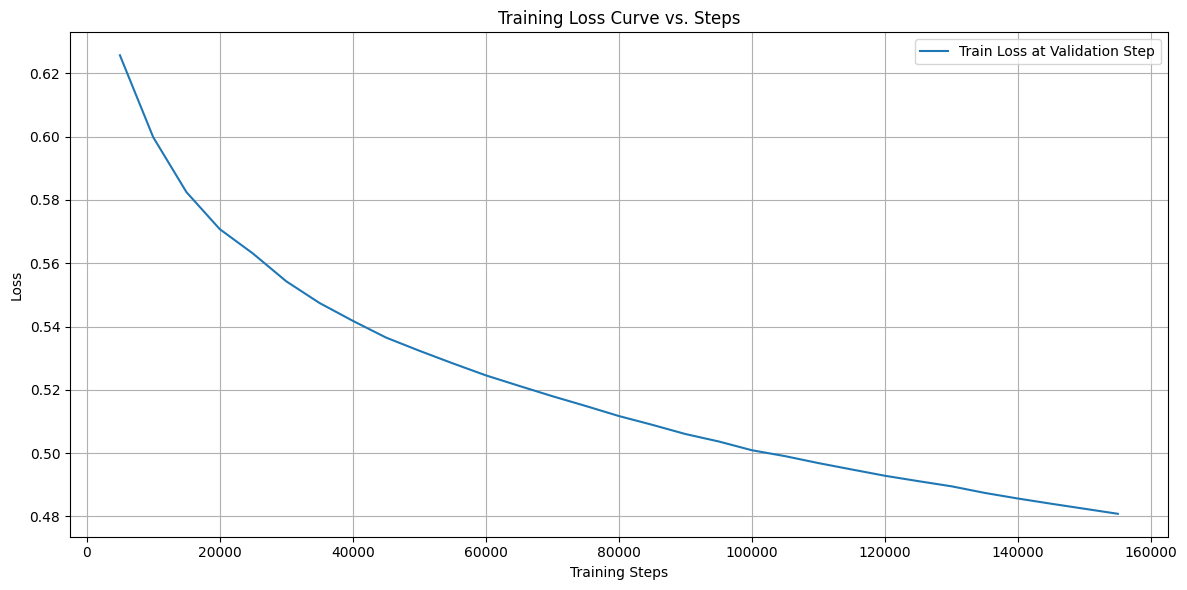

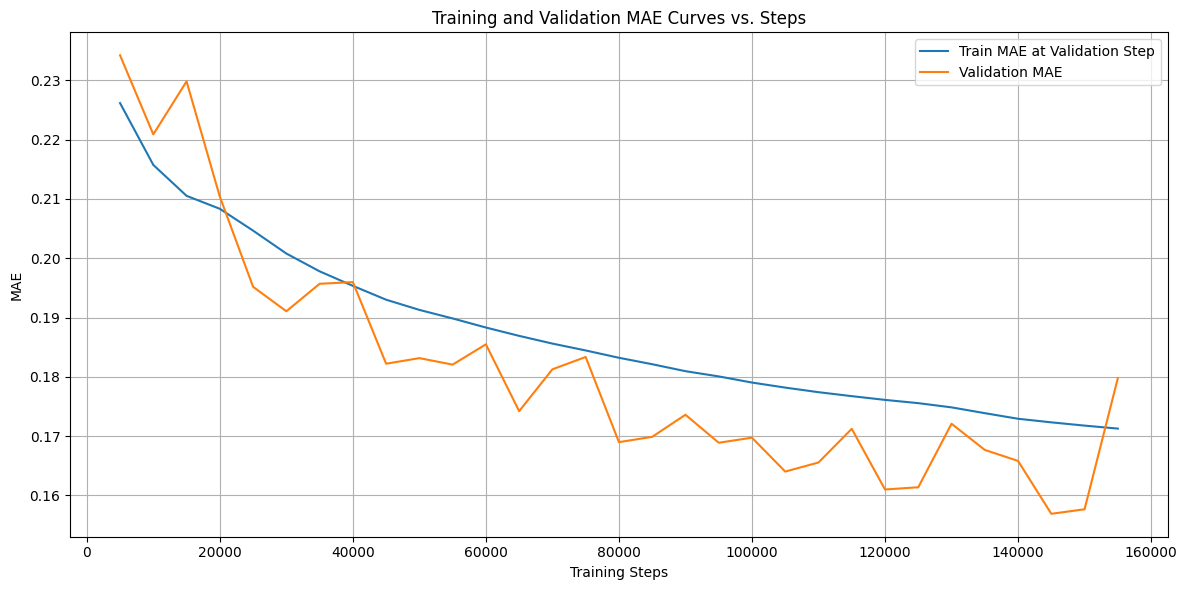

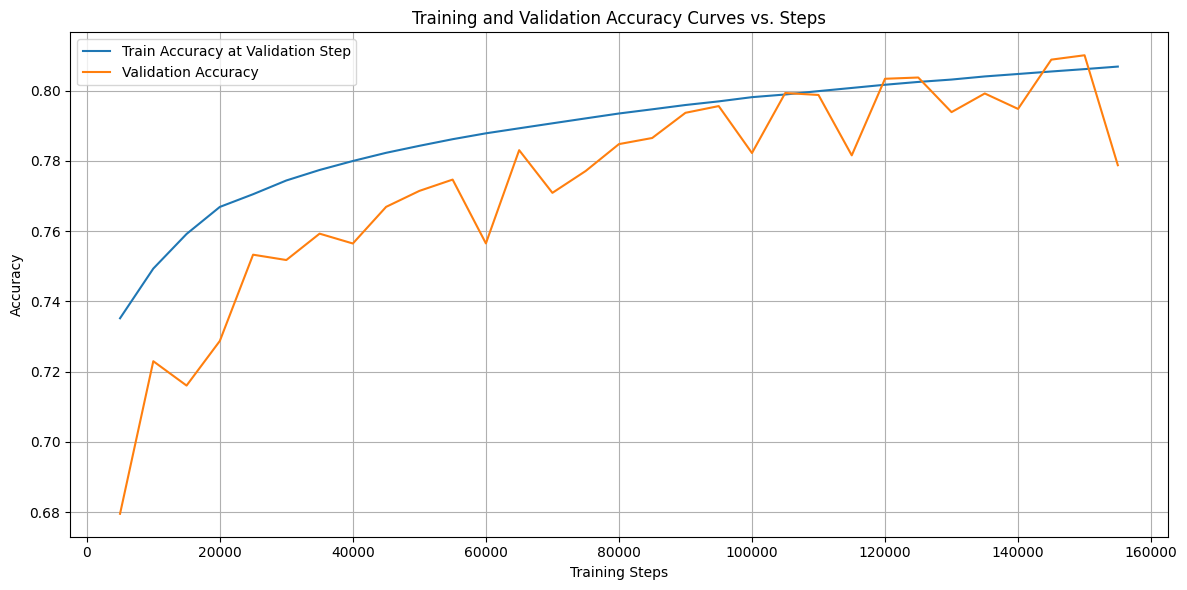

In [71]:
# --- Plotting Loss Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_losses, label='Train Loss at Validation Step')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting MAE Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_maes, label='Train MAE at Validation Step')
plt.plot(steps, val_maes, label='Validation MAE')
plt.xlabel('Training Steps')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting Accuracy Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_win_accs, label='Train Accuracy at Validation Step')
plt.plot(steps, val_win_accs, label='Validation Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# Show all the plots
plt.show()

In [77]:
test_inputs, test_labels, test_winning_labels = next(iter(test_loader))

# Send the inputs and labels to the device (e.g., GPU or CPU)
test_inputs = test_inputs.to(DEVICE)
test_labels = test_labels.to(DEVICE)
test_winning_labels = test_winning_labels.to(DEVICE)

# Set the model to evaluation mode
model.eval()

# Perform inference on the first test example
with torch.no_grad():
    # Run the model (assuming the model outputs both eval and win predictions)
    eval_pred, win_pred = model(test_inputs[0].unsqueeze(0))  # Run on the first sample in the batch

    # Print the output (predicted values)
    # print(test_inputs[0].unsqueeze(0))
    print("Predicted evaluation score:", round(eval_pred.item(),2))
    # print("Predicted win score:", win_pred.item())

    # Print the expected values (ground truth)
    print("Expected evaluation score:", round(test_labels[0].item(),2))
    # print("Expected win score:", test_winning_labels[0].item())

Predicted evaluation score: -0.03
Expected evaluation score: -0.09
